In [113]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import shutil

%matplotlib inline
plt.style.use('seaborn-whitegrid')

import itertools

import pandas as pd
import tensorflow as tf

'''
  DNN = Deep Neutral Network
'''

tf.logging.set_verbosity(tf.logging.ERROR)

DATASET_NAME = "Boston House Prices dataset"

DATASET_DOC ='''
:Attribute Information (in order):
   Featuers
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
       -x CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
       -x RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        
        -t : MDEV : Median Value is usually the target
'''

COLUMNS =  ["crim", "zn", "indus", "nox", "rm",  "age","dis", "tax",  "ptratio", "medv"]
FEATURES = ["crim", "zn", "indus", "nox", "rm",  "age", "dis", "tax", "ptratio"]
LABEL = "medv"
N_STEPS = 5000

 # Build 2 layer fully connected DNN with 10, 10 units respectively.
HIDDEN_UNITS = [15, 15]
MODEL_DIR ='/tmp/boston_model'

TRAINING_DATA_FILE = './boston/boston_train.csv'
TEST_DATA_FILE = './boston/boston_test.csv'
PREDICTION_DATA_FILE = './boston/boston_predict.csv'
LEARNING_RATE = 0.01

ADAM_OPTIMIZER = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
ADAGRAD_OPTIMIZER = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE)
OPTIMIZER1 = ADAM_OPTIMIZER
 

#=================
def input_fn(data_set):
  feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
  labels = tf.constant(data_set[LABEL].values)
  return feature_cols, labels

#=================
def prepare_data(training_datafile=TRAINING_DATA_FILE, test_datafile=TEST_DATA_FILE, prediction_datafile=PREDICTION_DATA_FILE):
    # Load datasets
  training_set = pd.read_csv(training_datafile, skipinitialspace=True,
                             skiprows=1, names=COLUMNS)
  test_set = pd.read_csv(test_datafile, skipinitialspace=True,
                         skiprows=1, names=COLUMNS)
  
  # Set of 6 examples for which to predict median house values
  prediction_set = pd.read_csv(prediction_datafile, skipinitialspace=True,
                               skiprows=1, names=COLUMNS)
  return training_set, test_set, prediction_set


#=================build, fit, predict, score_accuray

def build_model(feature_cols, hidden_units, model_dir, optimizer=OPTIMIZER1, learning_rate=LEARNING_RATE):
  print ('Building the model with:\n Optimizer: {0} \n learning_rate: {1} ...'.format(optimizer, learning_rate))
  shutil.rmtree(MODEL_DIR, ignore_errors=True) 
  return tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                        optimizer=optimizer,
                                        hidden_units=hidden_units,
                                        model_dir=MODEL_DIR)
def fit (training_set, regressor, n_steps=N_STEPS):
    regressor.fit(input_fn=lambda: input_fn(training_set), steps=n_steps)
    print ('Fitting the training test in the model with {0} steps ...'.format(n_steps))


def score_accuray(regressor, test_set, steps=1):
  # Score accuracy
  print ('Scoring model accuracy with test dataset...')
  ev = regressor.evaluate(input_fn=lambda: input_fn(test_set), steps=steps)
  loss_score = ev["loss"]
  print("Loss: {0:f}".format(loss_score))

def plot_real_vs_predicted(regressor, test_set):
  y_predicted = regressor.predict(input_fn=lambda: input_fn(test_set))
 

  plt.scatter( list(itertools.islice(y_predicted, test_set['medv'].count() )), test_set['medv'] )
  plt.scatter( test_set['medv'], test_set['medv'], c='red' )
  plt.xlabel( "Predicted Prices")
  plt.ylabel( "Real Prices")
  plt.title( "Real vs Predicted Housing Prices")



def predict(regressor,prediction_set ):
  print ('Predicting with the model...')
  # Print out predictions
  y = regressor.predict(input_fn=lambda: input_fn(prediction_set))
  # .predict() returns an iterator; convert to a list and print predictions
  predictions = list(itertools.islice(y, 6))
  print ('PRE', predictions)
  print("Predictions (Median value of owner-occupied homes in $1000's):\n {}".format(str(predictions)))
  

##------ plots
def draw_features_plot( features=['crim','nox', 'medv'],
                        xlabel='x', ylabel='y label goes here', df=training_set, title='Title here'):
    plt.figure()
    for feature in features:
        df[feature].plot()
    
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [65]:
def build_fit_predict(n_steps=N_STEPS, optimizer=OPTIMIZER1, learning_rate=LEARNING_RATE):
  # Load datasets
  training_set, test_set, prediction_set = prepare_data()

  # Feature cols
  feature_cols = [tf.contrib.layers.real_valued_column(k)
                  for k in FEATURES]

  # Build the model
  regressor = build_model(feature_cols, HIDDEN_UNITS, MODEL_DIR, optimizer=optimizer, learning_rate=learning_rate)
    

  
  # Fit
  fit(training_set, regressor, n_steps=n_steps)

  # Score accuracy
  score_accuray(regressor, test_set, steps=1)
  plot_real_vs_predicted(regressor, test_set)

  predict(regressor,prediction_set )


In [3]:
training_set, test_set, prediction_set = prepare_data()
print ("Training set shape: ", training_set.shape)
training_set[0:5]

Training set shape:  (400, 10)


,crim,zn,indus,nox,rm,age,dis,tax,ptratio,medv
0,2.30040,0.0,19.58,0.605,6.319,96.1,2.1000,403,14.7,23.8
1,13.35980,0.0,18.10,0.693,5.887,94.7,1.7821,666,20.2,12.7
2,0.12744,0.0,6.91,0.448,6.770,2.9,5.7209,233,17.9,26.6
3,0.15876,0.0,10.81,0.413,5.961,17.5,5.2873,305,19.2,21.7
4,0.03768,80.0,1.52,0.404,7.274,38.3,7.3090,329,12.6,34.6


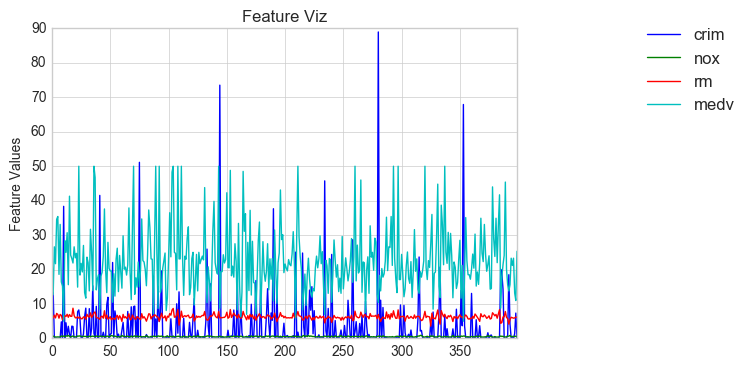

In [114]:
draw_features_plot(features=['crim','nox','rm',  'medv'], xlabel='', ylabel='Feature Values', title='Feature Viz')

In [4]:
print ("Test set shape: ", test_set.shape)
test_set[:5]

Test set shape:  (100, 10)


,crim,zn,indus,nox,rm,age,dis,tax,ptratio,medv
0,0.13587,0.0,10.59,0.489,6.064,59.1,4.2392,277,18.6,24.4
1,0.08664,45.0,3.44,0.437,7.178,26.3,6.4798,398,15.2,36.4
2,0.26938,0.0,9.90,0.544,6.266,82.8,3.2628,304,18.4,21.6
3,0.05302,0.0,3.41,0.489,7.079,63.1,3.4145,270,17.8,28.7
4,0.06860,0.0,2.89,0.445,7.416,62.5,3.4952,276,18.0,33.2


In [5]:
test_set['medv'][:5]
test_set['medv'].count()

100

In [6]:
print ("Predict set shape: ", prediction_set.shape)
prediction_set

Predict set shape:  (6, 10)


,crim,zn,indus,nox,rm,age,dis,tax,ptratio,medv
0,0.03359,75.0,2.95,0.428,7.024,15.8,5.4011,252,18.3,NaN
1,5.09017,0.0,18.10,0.713,6.297,91.8,2.3682,666,20.2,NaN
2,0.12650,25.0,5.13,0.453,6.762,43.4,7.9809,284,19.7,NaN
3,0.05515,33.0,2.18,0.472,7.236,41.1,4.0220,222,18.4,NaN
4,8.15174,0.0,18.10,0.700,5.390,98.9,1.7281,666,20.2,NaN
5,0.24522,0.0,9.90,0.544,5.782,71.7,4.0317,304,18.4,NaN


Building the model with:
 Optimizer: <tensorflow.python.training.adagrad.AdagradOptimizer object at 0x12203c7d0> 
 learning_rate: 0.02 ...


Exception AssertionError: AssertionError("Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects",) in <generator object run_feeds_iter at 0x12034c690> ignored
Exception AssertionError: AssertionError("Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects",) in <generator object run_feeds_iter at 0x1251bfb90> ignored


Fitting the training test in the model with 5000 steps ...
Scoring model accuracy with test dataset...
Loss: 30.588484
Predicting with the model...
PRE [33.525394, 18.681799, 28.076996, 31.965799, 16.051374, 22.09745]
Predictions (Median value of owner-occupied homes in $1000's):
 [33.525394, 18.681799, 28.076996, 31.965799, 16.051374, 22.09745]
CPU times: user 8.5 s, sys: 1.43 s, total: 9.93 s
Wall time: 7.59 s


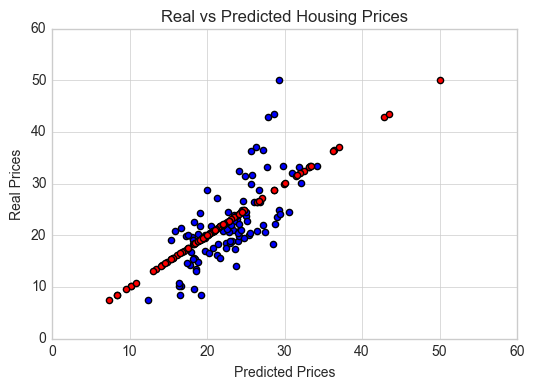

In [73]:
%%time
build_fit_predict(n_steps=5000,optimizer=ADAGRAD_OPTIMIZER, learning_rate=0.02)


In [29]:
%%bash
#tensorboard --logdir /tmp/boston_model &
open http://localhost:6006
